In [ ]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
from CoPhaser import gene_sets

import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "data/"
SCRNASEQ_DATA_FOLDER = "../../../data/"

height_ratios_scaling: [1, 1, 1, 1]


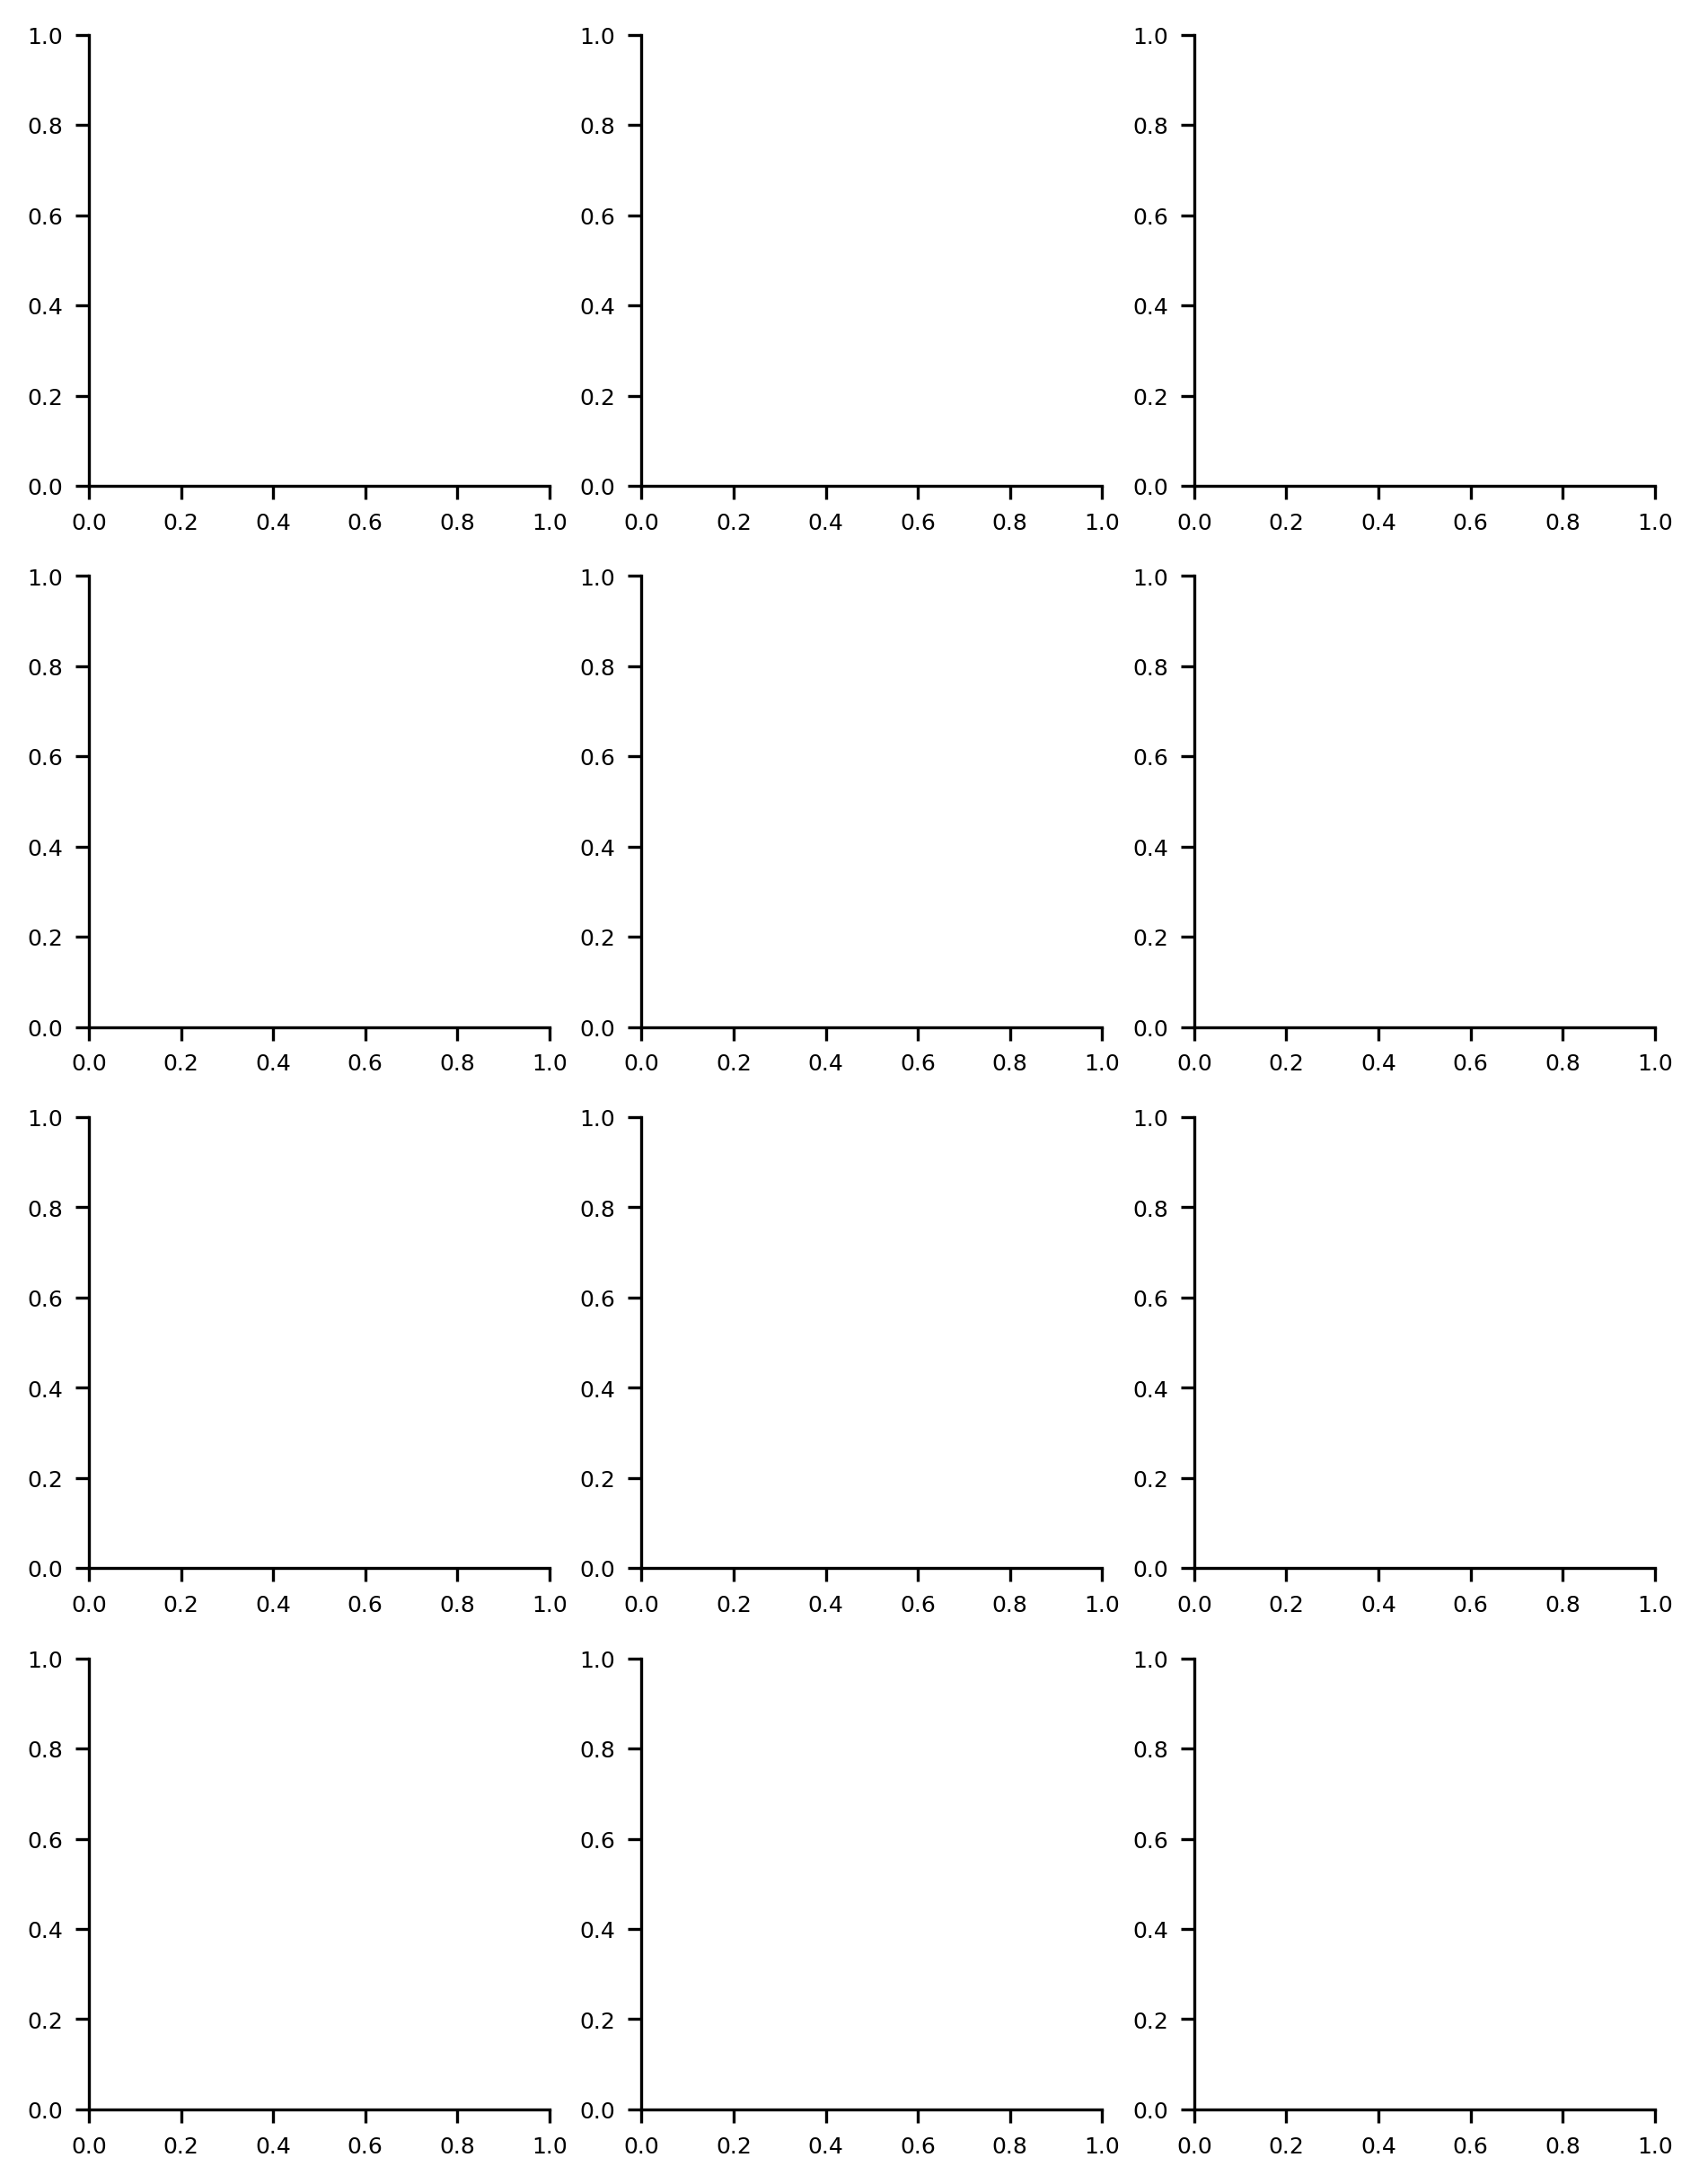

In [4]:
mosaic = [["A", "B", "C"], ["D", "E", "F"], ["G", "H", "I"], ["J", "K", "L"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [ ]:
breast_cancer = pickle.load(
    open(os.path.join(DATA_FOLDER, "breast_cancer_results.pkl"), "rb")
)
breast_cancer

{'z_space_embedding': array([[ 13.453772  ,   1.8798009 ],
        [ 15.209827  ,   1.0762023 ],
        [ 14.123289  ,   0.51939666],
        ...,
        [ -9.553252  ,  -2.6086369 ],
        [ -9.898246  ,  -3.035167  ],
        [-10.406434  ,  -2.9625492 ]], dtype=float32),
 'inferred_theta': array([ 0.15582252,  0.29155588,  1.3966305 , ..., -1.2312727 ,
        -1.3223536 , -1.6453419 ], dtype=float32),
 'cycling_cells': array([ True,  True,  True, ..., False,  True, False]),
 'latent_z': array([[ 0.37332025,  2.5333421 , -0.46433154, ...,  1.718476  ,
         -0.9878677 , -0.3008021 ],
        [ 0.85030633,  3.3389647 , -1.3104458 , ...,  1.7666677 ,
         -0.95434105,  0.33655956],
        [ 0.8152305 ,  3.4553273 , -0.7615098 , ...,  1.5899904 ,
         -1.4149601 ,  0.08895269],
        ...,
        [ 0.59145766,  2.1623764 , -1.5544022 , ...,  1.7311082 ,
          0.08773069,  2.0144174 ],
        [ 0.13439658,  2.4320266 , -1.5418478 , ...,  1.6831615 ,
         -0.68

In [6]:
adata = breast_cancer["adata"]

In [8]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions

In [9]:
ax = axs["A"]
plotting.plot_z_space_paper(
    breast_cancer["z_space_embedding"][:, 0],
    breast_cancer["z_space_embedding"][:, 1],
    ax=ax,
    alpha=0.7,
    hue=adata.obs["orig.ident"],
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    legend=True,
)
ax.legend(title="Subtype")

In [10]:
cycling_status = breast_cancer["cycling_cells"]
plot_helpers.make_polar(axs, "B")
plotting.plot_cell_cycle(breast_cancer["df_f"], ax=axs["B"])

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


In [11]:
ax = axs["C"]
plotting.modify_axis_labels(ax=ax, step=0.5)
plotting.plot_smoothed_profiles(
    utils.normalize_angles(breast_cancer["inferred_theta"][cycling_status]),
    get_gene_fractions("HIST1H4C", adata[cycling_status]) * 1e4,
    ax=ax,
    nbins=20,
    xlabel="Inferred Phase",
    ylabel="Normalized Counts",
    title="",
    hue=adata[cycling_status].obs["orig.ident"].values,
)
ax.set_title(f"H4C3", fontweight="bold", style="italic")
ax.legend(title="Subtype")
ax.set_ylim(bottom=0)

(0.0, 29.417703686927204)

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# G1/G0 fraction of cells per subtype
subtypes = adata.obs["orig.ident"]
G1_G0_cells = (
    (breast_cancer["inferred_theta"] > -0.75 * np.pi)
    & (breast_cancer["inferred_theta"] < -0.25 * np.pi)
) | ~cycling_status
barplot_df = pd.DataFrame(
    {
        "subtype": subtypes,
        "Proliferating_cells": ~G1_G0_cells,
        "patient_id": adata.obs["group"].values,
    }
)
# 1. Compute patient-level means
patient_means = (
    barplot_df.groupby(["subtype", "patient_id"])["Proliferating_cells"]
    .mean()
    .reset_index()
)

# Organize values per subtype
subtype_groups = {
    subtype: df["Proliferating_cells"].values
    for subtype, df in patient_means.groupby("subtype")
}

summary = (
    patient_means.groupby(["subtype", "patient_id"])["Proliferating_cells"]
    .mean()
    .groupby("subtype")
    .agg(mean="mean", sem="sem")
    .reset_index()
)

# 3. Barplot with SEM
ax = axs["D"]
ax.bar(summary["subtype"], summary["mean"], yerr=summary["sem"], capsize=5)

ax.set_ylabel("Proliferating Cells Fraction")
ax.set_xlabel("Subtype")
ax.set_title("Proliferating Cells Fraction")

/tmp/ipykernel_1493196/569763396.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  barplot_df.groupby(["subtype", "patient_id"])["Proliferating_cells"]
/tmp/ipykernel_1493196/569763396.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for subtype, df in patient_means.groupby("subtype")
/tmp/ipykernel_1493196/569763396.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patient_means.groupby(["subtype", "patient_id

Text(0.5, 1.0, 'Proliferating Cells Fraction')

In [14]:
df_z = breast_cancer["df_z"]

In [15]:
df_rhythmic = breast_cancer["df_f"]

In [16]:
ptp = utils.get_ptp_phase(df_rhythmic)

In [17]:
df_z = breast_cancer["df_z"]
df_z["subtype"] = adata.obs["orig.ident"].values
df_z = df_z.loc[
    :,
    [g for g in utils.get_ptp_phase(df_rhythmic).loc[ptp["peak_to_peak"] < 1].index]
    + ["subtype"],
]
fractions = (
    (adata[:, df_z.columns[:-1]].layers["total"] / adata.layers["total"].sum(axis=1))
    .mean(axis=0)
    .A1
)
df_z = df_z.loc[:, list(fractions > 5e-5) + [True]]
res = (df_z.groupby("subtype").median().var()).sort_values(ascending=False).head(60)
# merge res to get peaking phase
res = pd.DataFrame(res)
res = res.merge(ptp, left_index=True, right_index=True)
# add the indication of wich subtype has the highest expression
highest_subtype = (
    df_z.groupby("subtype")
    .median()
    .apply(lambda x: x.idxmax(), axis=0)
    .to_frame(name="highest_subtype")
)
res = res.merge(highest_subtype, left_index=True, right_index=True)
res.head(10)

/tmp/ipykernel_1493196/2235230782.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = (df_z.groupby("subtype").median().var()).sort_values(ascending=False).head(60)
/tmp/ipykernel_1493196/2235230782.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_z.groupby("subtype")


,0,peak_to_peak,phase,highest_subtype
KRT14,20.924870,0.572206,-1.111981,TN
KRT6B,17.863169,0.151421,-1.331311,TN
KRT6A,16.812937,0.692500,2.814813,TN
KRT5,15.473297,0.259104,-0.081223,TN
KRT17,14.843623,0.734374,2.814813,TN
SFRP1,14.472250,0.697081,0.204972,TN
GABRP,14.266810,0.632831,2.814813,TN
FDCSP,14.234172,0.570157,0.204972,TN
SERPINB5,13.674256,0.268663,2.814813,TN
SAA1,11.356261,0.301253,-0.118261,TN


In [18]:
df_z = breast_cancer["df_z"]
df_z["subtype"] = adata.obs["orig.ident"].values
df_z = df_z.loc[
    :,
    [g for g in utils.get_ptp_phase(df_rhythmic).loc[ptp["peak_to_peak"] > 2].index]
    + ["subtype"],
]
fractions = (
    (adata[:, df_z.columns[:-1]].layers["total"] / adata.layers["total"].sum(axis=1))
    .mean(axis=0)
    .A1
)
df_z = df_z.loc[:, list(fractions > 1e-5) + [True]]
res = (df_z.groupby("subtype").median().var()).sort_values(ascending=False).head(60)
# merge res to get peaking phase
res = pd.DataFrame(res)
res = res.merge(ptp, left_index=True, right_index=True)
# add the indication of wich subtype has the highest expression
highest_subtype = (
    df_z.groupby("subtype")
    .median()
    .apply(lambda x: x.idxmax(), axis=0)
    .to_frame(name="highest_subtype")
)
res = res.merge(highest_subtype, left_index=True, right_index=True)
res.head(10)

/tmp/ipykernel_1493196/111997043.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = (df_z.groupby("subtype").median().var()).sort_values(ascending=False).head(60)
/tmp/ipykernel_1493196/111997043.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_z.groupby("subtype")


,0,peak_to_peak,phase,highest_subtype
RHCG,9.603669,2.079099,-0.671797,TN
CCL20,6.072612,2.143702,1.389786,TN
HOTAIRM1,2.791940,2.045189,-2.301529,TN
PLAU,2.286911,2.030870,0.204972,TN
CDCA7,1.597226,4.453731,0.204972,TN
CDC20,1.037617,8.549220,2.814813,TN
LGALS1,0.760245,2.270461,-3.068110,TN
TYMS,0.747410,5.679572,1.389786,TN
NDC80,0.715893,8.083937,2.814813,TN
ASF1B,0.665056,5.478653,1.052126,TN


In [19]:
adata[:, df_z.columns[:-1]].layers["total"].mean(axis=0).A1

array([0.22854695, 0.26829708, 1.4395077 , 0.14157286, 0.45671588,
       0.13916408, 0.21871285, 0.1557381 , 0.7893072 , 0.21468613,
       0.06611853, 5.2062874 , 0.2577835 , 0.15753227, 0.5243579 ,
       1.1243033 , 0.08183001, 1.1759851 , 0.15304263, 0.1039122 ,
       0.6167349 , 0.6199076 , 0.12976134, 0.14085825, 0.18277773,
       0.16548248, 0.20647898, 0.54672927, 0.11988084, 0.39821637,
       0.21672735, 0.138626  , 0.45668074, 0.20422482, 0.1300416 ,
       0.16003029, 1.4508574 , 0.12023161, 0.15565577, 1.6304971 ,
       0.28584054, 2.586939  , 0.7461983 , 0.30448046, 0.1737683 ,
       1.7850974 , 0.3290107 , 0.2198857 , 1.449554  , 0.15239222,
       0.15186693, 0.1062619 , 0.21620582, 0.08906604, 1.9066936 ,
       0.3514554 , 0.5003331 , 0.29786557, 0.50838774, 0.14757098,
       0.10843644, 0.33443952, 0.1604867 , 0.08792032, 0.27021614,
       0.26433313, 0.19398   , 0.26832265, 3.068618  , 0.20617555,
       0.14160928, 0.6960525 , 0.1553877 , 0.53087133, 0.09959

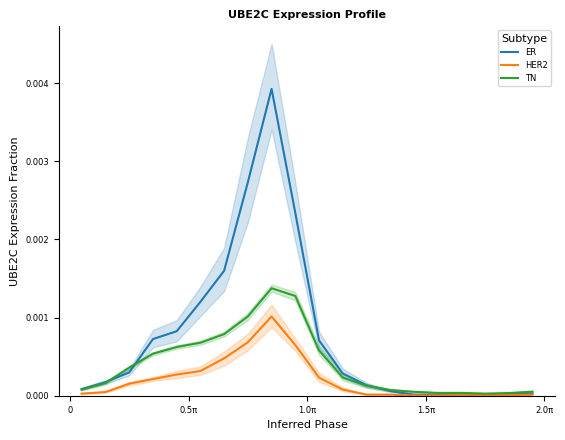

<Axes: xlabel='orig.ident'>

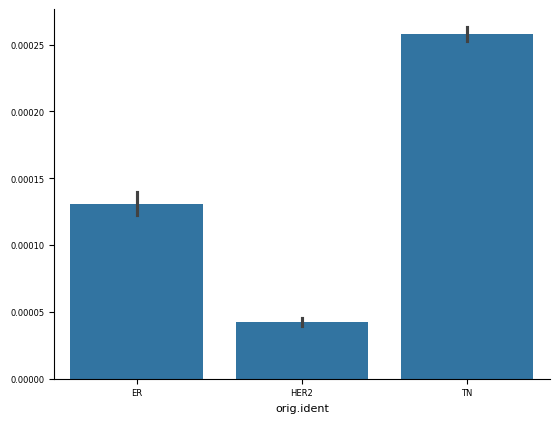

In [20]:
ax = plt.gca()
plotting.modify_axis_labels(ax=ax, step=0.5, offset=np.pi)
gene = "UBE2C"
plotting.plot_smoothed_profiles(
    utils.normalize_angles(breast_cancer["inferred_theta"][cycling_status] - np.pi)
    + np.pi,
    get_gene_fractions(gene, adata[cycling_status]),
    ax=ax,
    nbins=20,
    xlabel="Inferred Phase",
    ylabel=f"{gene} Expression Fraction",
    title=f"{gene} Expression Profile",
    hue=adata[cycling_status].obs["orig.ident"].values,
)
ax.legend(title="Subtype")
ax.set_ylim(bottom=0)
plt.show()
ax = plt.gca()
sns.barplot(
    x=adata.obs["orig.ident"],
    y=get_gene_fractions(gene, adata),
    ax=ax,
)

In [21]:
def plot_gene_expression_profile(ax, gene):
    plotting.modify_axis_labels(ax=ax, step=0.5, offset=np.pi)
    plotting.plot_smoothed_profiles(
        utils.normalize_angles(breast_cancer["inferred_theta"][cycling_status] - np.pi)
        + np.pi,
        np.log1p(get_gene_fractions(gene, adata[cycling_status]) * 1e4),
        ax=ax,
        nbins=20,
        xlabel="Inferred Phase",
        ylabel=f"Normalized Counts (log)",
        title=f"",
        hue=adata[cycling_status].obs["orig.ident"].values,
    )
    ax.set_title(f"{gene}", fontweight="bold", style="italic")
    ax.legend(title="Subtype")
    ax.set_ylim(bottom=0)


plot_gene_expression_profile(axs["E"], "CDC20")
plot_gene_expression_profile(axs["F"], "KRT14")

In [23]:
pediatric_aml = pickle.load(open(os.path.join(DATA_FOLDER, "pediatric_AML.pkl"), "rb"))
pediatric_aml

{'z_space_embedding': array([[ 2.5561152 , -6.481769  ],
        [16.331743  , 11.699138  ],
        [-0.52440226, -4.93733   ],
        ...,
        [15.640232  , -2.6159835 ],
        [-3.6016643 , -4.126458  ],
        [ 8.069708  ,  8.384726  ]], dtype=float32),
 'inferred_theta': array([-3.0396245, -2.4219258, -2.0254095, ..., -2.2524426, -2.3294318,
        -2.251279 ], dtype=float32),
 'cycling_cells': array([False, False, False, ..., False, False, False]),
 'latent_z': array([[-0.8631499 , -1.4890265 ,  1.7039591 , ...,  0.5811543 ,
          0.3291146 ,  0.15435264],
        [-0.27354324, -0.8837525 , -0.69724053, ..., -2.1305141 ,
          0.93229663, -1.392461  ],
        [ 0.869895  , -0.79457694,  0.18148074, ...,  1.9572536 ,
          0.5817861 ,  0.57708806],
        ...,
        [-1.7820222 ,  0.6504992 ,  0.6586789 , ..., -0.5621695 ,
         -2.040071  , -2.996825  ],
        [-0.00645644,  2.856797  ,  0.58965904, ...,  2.7201688 ,
         -0.48885024, -0.6901364

In [24]:
adata = pediatric_aml["adata"]
cycling_status = pediatric_aml["cycling_cells"]
adata.obs

,GEO_ID,Lambo_et_al_ID,Patient_Sample,Library_ID,Counts,Features,Mitochondria_percent,Classified_Celltype,Seurat_Cluster,Malignant,...,sample_id,batch,n_cell_cycle_counts,pca_theta,histones_fraction,inferred_thetas,library_size,inferred_theta,disease_status,dividing
AAACCCAAGAACGCGT-1,PAVJXG_Rel_scRNA,AML8,Relapse,AML8_REL,11235,2151,7.556742,Progenitor,0,Malignant,...,GSM7494275_AML8_REL,GSM7494275_AML8_REL,0.000445,-3.049478,0.000178,-3.039624,11235.0,-3.039624,Relapse,False
AAACCCAAGAAGGATG-1,PAWWCW_Rel_scRNA,AML11,Relapse,AML11_REL,4352,1129,6.571691,CD4.Naive,1,Normal,...,GSM7494296_AML11_REL,GSM7494296_AML11_REL,0.000919,-3.060291,0.000000,-2.421926,4352.0,-2.421926,Relapse,False
AAACCCAAGAATCGCG-1,PAWNYX_Dx_scRNA,AML6,Diagnosis,AML6_DX,7211,2064,9.638053,GMP,1,Malignant,...,GSM7494260_AML6_DX,GSM7494260_AML6_DX,0.000555,-2.959128,0.000000,-2.025409,7211.0,-2.025409,Diagnosis,False
AAACCCAAGACGATAT-1,PAVGJG_Dx_scRNA,AML18,Diagnosis,AML18_DX,14966,3790,5.672858,Progenitor,8,Malignant,...,GSM7494324_AML18_DX,GSM7494324_AML18_DX,0.005212,0.320318,0.001136,-0.547283,14966.0,-0.547283,Diagnosis,False
AAACCCAAGACGCCCT-1,PAUVAT_Rel_scRNA,AML26,Relapse,AML26_REL,10567,2983,7.192202,Progenitor,4,Malignant,...,GSM7494320_AML26_REL,GSM7494320_AML26_REL,0.002271,2.185501,0.000000,-1.209308,10567.0,-1.209308,Relapse,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTGATGGT-1,PAWUAE_Dx_scRNA,AML5,Diagnosis,AML5_DX,8566,2543,7.681532,Monocytes,11,Malignant,...,GSM7494279_AML5_DX,GSM7494279_AML5_DX,0.001401,-1.521373,0.000817,-2.234470,8566.0,-2.234470,Diagnosis,False
TTTGTTGTCTGATTCT-1,PAWNPG_Rem_scRNA,AML13,Remission,AML13_REM,2125,880,6.635294,GMP,3,Normal,...,GSM7494331_AML13_REM,GSM7494331_AML13_REM,0.011294,-0.708146,0.003765,2.354351,2125.0,2.354351,Remission,True
TTTGTTGTCTGGACCG-1,PAUZRT_Rel_scRNA,AML16,Relapse,AML16_REL,9354,2477,7.258927,HSC,10,Malignant,...,GSM7494258_AML16_REL,GSM7494258_AML16_REL,0.001176,-3.088533,0.001283,-2.252443,9354.0,-2.252443,Relapse,False
TTTGTTGTCTGGTTGA-1,PAWRVC_Dx_scRNA,AML9,Diagnosis,AML9_DX,6593,2056,5.156985,Monocytes,1,Malignant,...,GSM7494289_AML9_DX,GSM7494289_AML9_DX,0.002123,-2.833030,0.000455,-2.329432,6593.0,-2.329432,Diagnosis,False


In [25]:
adata.obs.columns

Index(['GEO_ID', 'Lambo_et_al_ID', 'Patient_Sample', 'Library_ID', 'Counts',
       'Features', 'Mitochondria_percent', 'Classified_Celltype',
       'Seurat_Cluster', 'Malignant', 'Patient_ID', 'Biopsy_Origin',
       'Age_Months', 'Disease_free_days', 'Clinical_Blast_Percent',
       'Expected_Driving_Aberration', 'Subgroup', 'Color_Subgroup',
       'Known_CNVs', 'Treatment_Outcome', 'nCount_RNA', 'nFeature_RNA',
       'sample_id', 'batch', 'n_cell_cycle_counts', 'pca_theta',
       'histones_fraction', 'inferred_thetas', 'library_size',
       'inferred_theta', 'disease_status', 'dividing'],
      dtype='object')

In [27]:
adata.obs["Expected_Driving_Aberration"].value_counts()

Expected_Driving_Aberration
RUNX1-RUNX1T1        35647
KMT2A-MLLT3          29737
CBFB-MYH11           22823
KMT2A-MLLT10         20298
FLT3-ITD             14372
KMT2A-MLLT4          12062
MLLT10-NAP1L1         9715
NUP98-NSD1            8230
SPTBN1-ALK            6908
KMT2A-AFF3            5930
SFPQ-ZFP36L2          3239
KMT2A-PALM2.AKAP2     2865
KMT2A-SEPT6           1534
Name: count, dtype: int64

In [28]:
ax = axs["G"]
random_sampling_points = adata.obs.sample(n=30000, random_state=42)
# transform to mask
random_sampling_mask = adata.obs.index.isin(random_sampling_points.index)
plotting.plot_z_space_paper(
    pediatric_aml["z_space_embedding"][random_sampling_mask, 0],
    pediatric_aml["z_space_embedding"][random_sampling_mask, 1],
    ax=ax,
    alpha=0.7,
    hue=adata[random_sampling_mask].obs["Subgroup"].values,
    xlabel="UMAP 1",
    ylabel="UMAP 2",
    legend=True,
    size=5,
    legend_prop_ax=0.2,
)

In [29]:
plot_helpers.make_polar(axs, "H")
plotting.plot_cell_cycle(pediatric_aml["df_f"], ax=axs["H"])

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


In [30]:
ax = axs["I"]
i = adata.obs["Classified_Celltype"].isin(
    [
        "Progenitor",
        "GMP",
        "Pre.B.Cell",
        "CLP",
        "Early.Erythrocyte",
        "Late.Erythrocyte",
        "Monocytes",
        "HSC",
    ]
)
plotting.modify_axis_labels(ax=ax, step=0.5)

plotting.plot_smoothed_profiles(
    utils.normalize_angles(pediatric_aml["inferred_theta"]),
    get_gene_fractions("HIST1H4C", adata) * 1e4,
    ax=ax,
    nbins=20,
    xlabel="Inferred Phase",
    ylabel="Normalized Counts",
    title="",
    hue=adata.obs["Subgroup"].astype(str).values,
    add_end_start_points=True,
    hue_order=sorted(adata.obs["Subgroup"].astype(str).unique()),
)
ax.set_title(f"H4C3", fontweight="bold", style="italic")
ax.legend(title="Subtype")
ax.set_ylim(bottom=0)
ax.set_xlim(-np.pi, np.pi)

(-3.141592653589793, 3.141592653589793)

In [31]:
proliferating_cells = (cycling_status) & (adata.obs["inferred_theta"] > 0.25 * np.pi)
malignant_cells = (adata.obs["Malignant"] == "Malignant").values
df = pd.DataFrame(
    {
        "cell_type": adata[malignant_cells].obs["Classified_Celltype"].values,
        "patient_id": adata[malignant_cells].obs["Lambo_et_al_ID"].values,
        "Subtype": adata[malignant_cells].obs["Patient_Sample"].values,
        "Cycling_cells": proliferating_cells[malignant_cells],
    }
)
# drop remission subtypes, because they are not supposed to have malignant cells
df = df[df["Subtype"] != "Remission"]
# Count by patient × (cell_type, Subtype)
counts = df.groupby(["patient_id", "cell_type", "Subtype"], observed=True)[
    "Cycling_cells"
].mean()
counts.unstack().head()
# get the mean across patients
mean_counts = counts.groupby(["cell_type", "Subtype"], observed=True).mean()
mean_counts = mean_counts.unstack()
# get SEM across patients
sem_counts = counts.groupby(["cell_type", "Subtype"], observed=True).sem()
sem_counts = sem_counts.unstack()
# sort values by total mean proportion
mean_counts["Total"] = mean_counts.sum(axis=1)
mean_counts = mean_counts.sort_values(by="Total", ascending=False)
sem_counts = sem_counts.loc[mean_counts.index]
mean_counts = mean_counts.drop(columns=["Total"]).head(8)
sem_counts = sem_counts.loc[mean_counts.index]
# prepare dataframe for seaborn
plot_df = mean_counts.reset_index().melt(
    id_vars="cell_type", var_name="Subtype", value_name="mean"
)
sem_df = sem_counts.reset_index().melt(
    id_vars="cell_type", var_name="Subtype", value_name="sem"
)
plot_df = plot_df.merge(sem_df, on=["cell_type", "Subtype"])
plot_df["cell_type"] = plot_df["cell_type"].astype(str)

cell_types = mean_counts.index.tolist()
cell_type_unique = mean_counts.index.tolist()
cell_type_unique = [
    "Erythro.1" if ct == "Early.Erythrocyte" else ct for ct in cell_type_unique
]
cell_type_unique = [
    "Erythro.2" if ct == "Late.Erythrocyte" else ct for ct in cell_type_unique
]
cell_type_unique = [
    "E.Basophil" if ct == "Early.Basophil" else ct for ct in cell_type_unique
]
cell_type_unique = ["CD4.Mem" if ct == "CD4.Memory" else ct for ct in cell_type_unique]
subtypes = mean_counts.columns.tolist()
ax = axs["J"]
sns.barplot(
    data=plot_df,
    x="cell_type",
    y="mean",
    hue="Subtype",
    errorbar=None,
    dodge=True,
    ax=ax,
)

ax.set_xticklabels(cell_type_unique, rotation=45, ha="right")
ax.legend(title="Sampling Time")
ax.set_ylabel(f"Fraction of Proliferating Cells")
ax.set_xlabel("Cell Type")
ax.set_title(f"Proliferating Cell Types")

# ---------------------------------------------------
# 3. Matplotlib errorbars on top of seaborn bars
# ---------------------------------------------------
for i, subtype in enumerate(subtypes):
    sub_df = plot_df[plot_df["Subtype"] == subtype]
    for j, ct in enumerate(cell_types):
        if ct not in sub_df["cell_type"].values:
            continue
        row = sub_df[sub_df["cell_type"] == ct].iloc[0]

        # Locate bar drawn by seaborn
        bar = ax.patches[i * len(cell_types) + j]
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        # Add errorbar
        if y == 0:
            continue
        ax.errorbar(
            x,
            y,
            yerr=row["sem"],
            fmt="none",
            ecolor="black",
            capsize=1.5,
            linewidth=0.9,
        )

/tmp/ipykernel_1493196/4226139976.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_type_unique, rotation=45, ha="right")


In [33]:
def plot_proportion_cell_types(i_to_keep, ax, kept_cells_label=""):
    df = pd.DataFrame(
        {
            "cell_type": adata[i_to_keep].obs["Classified_Celltype"].values,
            "patient_id": adata[i_to_keep].obs["GEO_ID"].values,
            "Subtype": adata[i_to_keep].obs["Patient_Sample"].values,
        }
    )
    # drop remission subtypes, because they are not supposed to have malignant cells
    df = df[df["Subtype"] != "Remission"]
    # Count by patient × (cell_type, Subtype)
    counts = (
        df.groupby(["patient_id", "cell_type", "Subtype"], observed=True)
        .size()
        .unstack(["cell_type", "Subtype"], fill_value=0)
    )

    # ---------------------------------------------------
    # 1. Normalize ACROSS cell types for each patient
    # ---------------------------------------------------
    proportions = counts.astype(float).copy()

    for st in proportions.columns.get_level_values("Subtype").unique():

        # select all cell types for this subtype
        cols_st = proportions.loc[:, pd.IndexSlice[:, st]]

        # total across cell types for this subtype (per patient)
        totals = cols_st.sum(axis=1).astype(float)

        # normalize only this subtype's cell types, cast to float to avoid integer division
        totals = totals.astype(float)
        proportions.loc[:, pd.IndexSlice[:, st]] = cols_st.div(totals, axis=0)

    # Mean and SEM across patients
    mean_df = proportions.mean(axis=0)
    sem_df = proportions.std(axis=0, ddof=1) / np.sqrt(proportions.shape[0])

    # Prepare plotting dataframe
    plot_df = pd.DataFrame(
        {
            "cell_type": [ct for ct, st in mean_df.index],
            "Subtype": [st for ct, st in mean_df.index],
            "mean": mean_df.values,
            "sem": sem_df.values,
        }
    )

    # sort cell types by overall mean proportion and take top 8
    cell_type_means = plot_df.groupby("cell_type")["mean"].mean()
    plot_df["key"] = plot_df["cell_type"].map(cell_type_means)
    plot_df = plot_df[
        plot_df["cell_type"].isin(
            cell_type_means.sort_values(ascending=False).head(8).index
        )
    ]

    plot_df = plot_df.sort_values(by=["key", "cell_type"], ascending=[False, True])
    cell_types = plot_df["cell_type"].unique()
    subtypes = sorted(plot_df["Subtype"].unique())

    # ---------------------------------------------------
    # 2. Seaborn barplot (no CI)
    # ---------------------------------------------------
    # add a \n 1 over 2 cell types for better readability
    cell_type_unique = plot_df["cell_type"].unique()
    # replace Early.erythrocyte with E. Erythro. and Late.erythrocyte with L. Erythro.
    cell_type_unique = [
        "Erythro.1" if ct == "Early.Erythrocyte" else ct for ct in cell_type_unique
    ]
    cell_type_unique = [
        "Erythro.2" if ct == "Late.Erythrocyte" else ct for ct in cell_type_unique
    ]
    cell_type_labels = []
    # for i, ct in enumerate(cell_type_unique):
    #     cell_type_labels.append("\n" * (i % 3) + ct)
    sns.barplot(
        data=plot_df,
        x="cell_type",
        y="mean",
        hue="Subtype",
        errorbar=None,
        dodge=True,
        ax=ax,
    )

    ax.set_xticklabels(cell_type_unique, rotation=45, ha="right")
    ax.legend(title="Sampling Time")
    ax.set_ylabel(f"Fraction of Cell Types")
    ax.set_xlabel("Cell Type")
    ax.set_title(f"{kept_cells_label} Malignant Cell")

    # ---------------------------------------------------
    # 3. Matplotlib errorbars on top of seaborn bars
    # ---------------------------------------------------
    for i, subtype in enumerate(subtypes):
        sub_df = plot_df[plot_df["Subtype"] == subtype]
        for j, ct in enumerate(cell_types):
            if ct not in sub_df["cell_type"].values:
                continue
            row = sub_df[sub_df["cell_type"] == ct].iloc[0]

            # Locate bar drawn by seaborn
            bar = ax.patches[i * len(cell_types) + j]
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_height()

            # Add errorbar
            if y == 0:
                continue
            ax.errorbar(
                x,
                y,
                yerr=row["sem"],
                fmt="none",
                ecolor="black",
                capsize=1.5,
                linewidth=0.9,
            )


proliferating_cells = ((cycling_status) & (adata.obs["inferred_theta"] > 1)) & (
    adata.obs["Malignant"] == "Malignant"
)
plot_proportion_cell_types(
    proliferating_cells, axs["K"], kept_cells_label="Proliferating"
)
non_proliferating_cells = (~((cycling_status) & (adata.obs["inferred_theta"] > 1))) & (
    adata.obs["Malignant"] == "Malignant"
)
plot_proportion_cell_types(non_proliferating_cells, axs["L"], kept_cells_label="G0/G1")

/tmp/ipykernel_1493196/1064498106.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_type_unique, rotation=45, ha="right")
/tmp/ipykernel_1493196/1064498106.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_type_unique, rotation=45, ha="right")


Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_3_cancer_python.svg


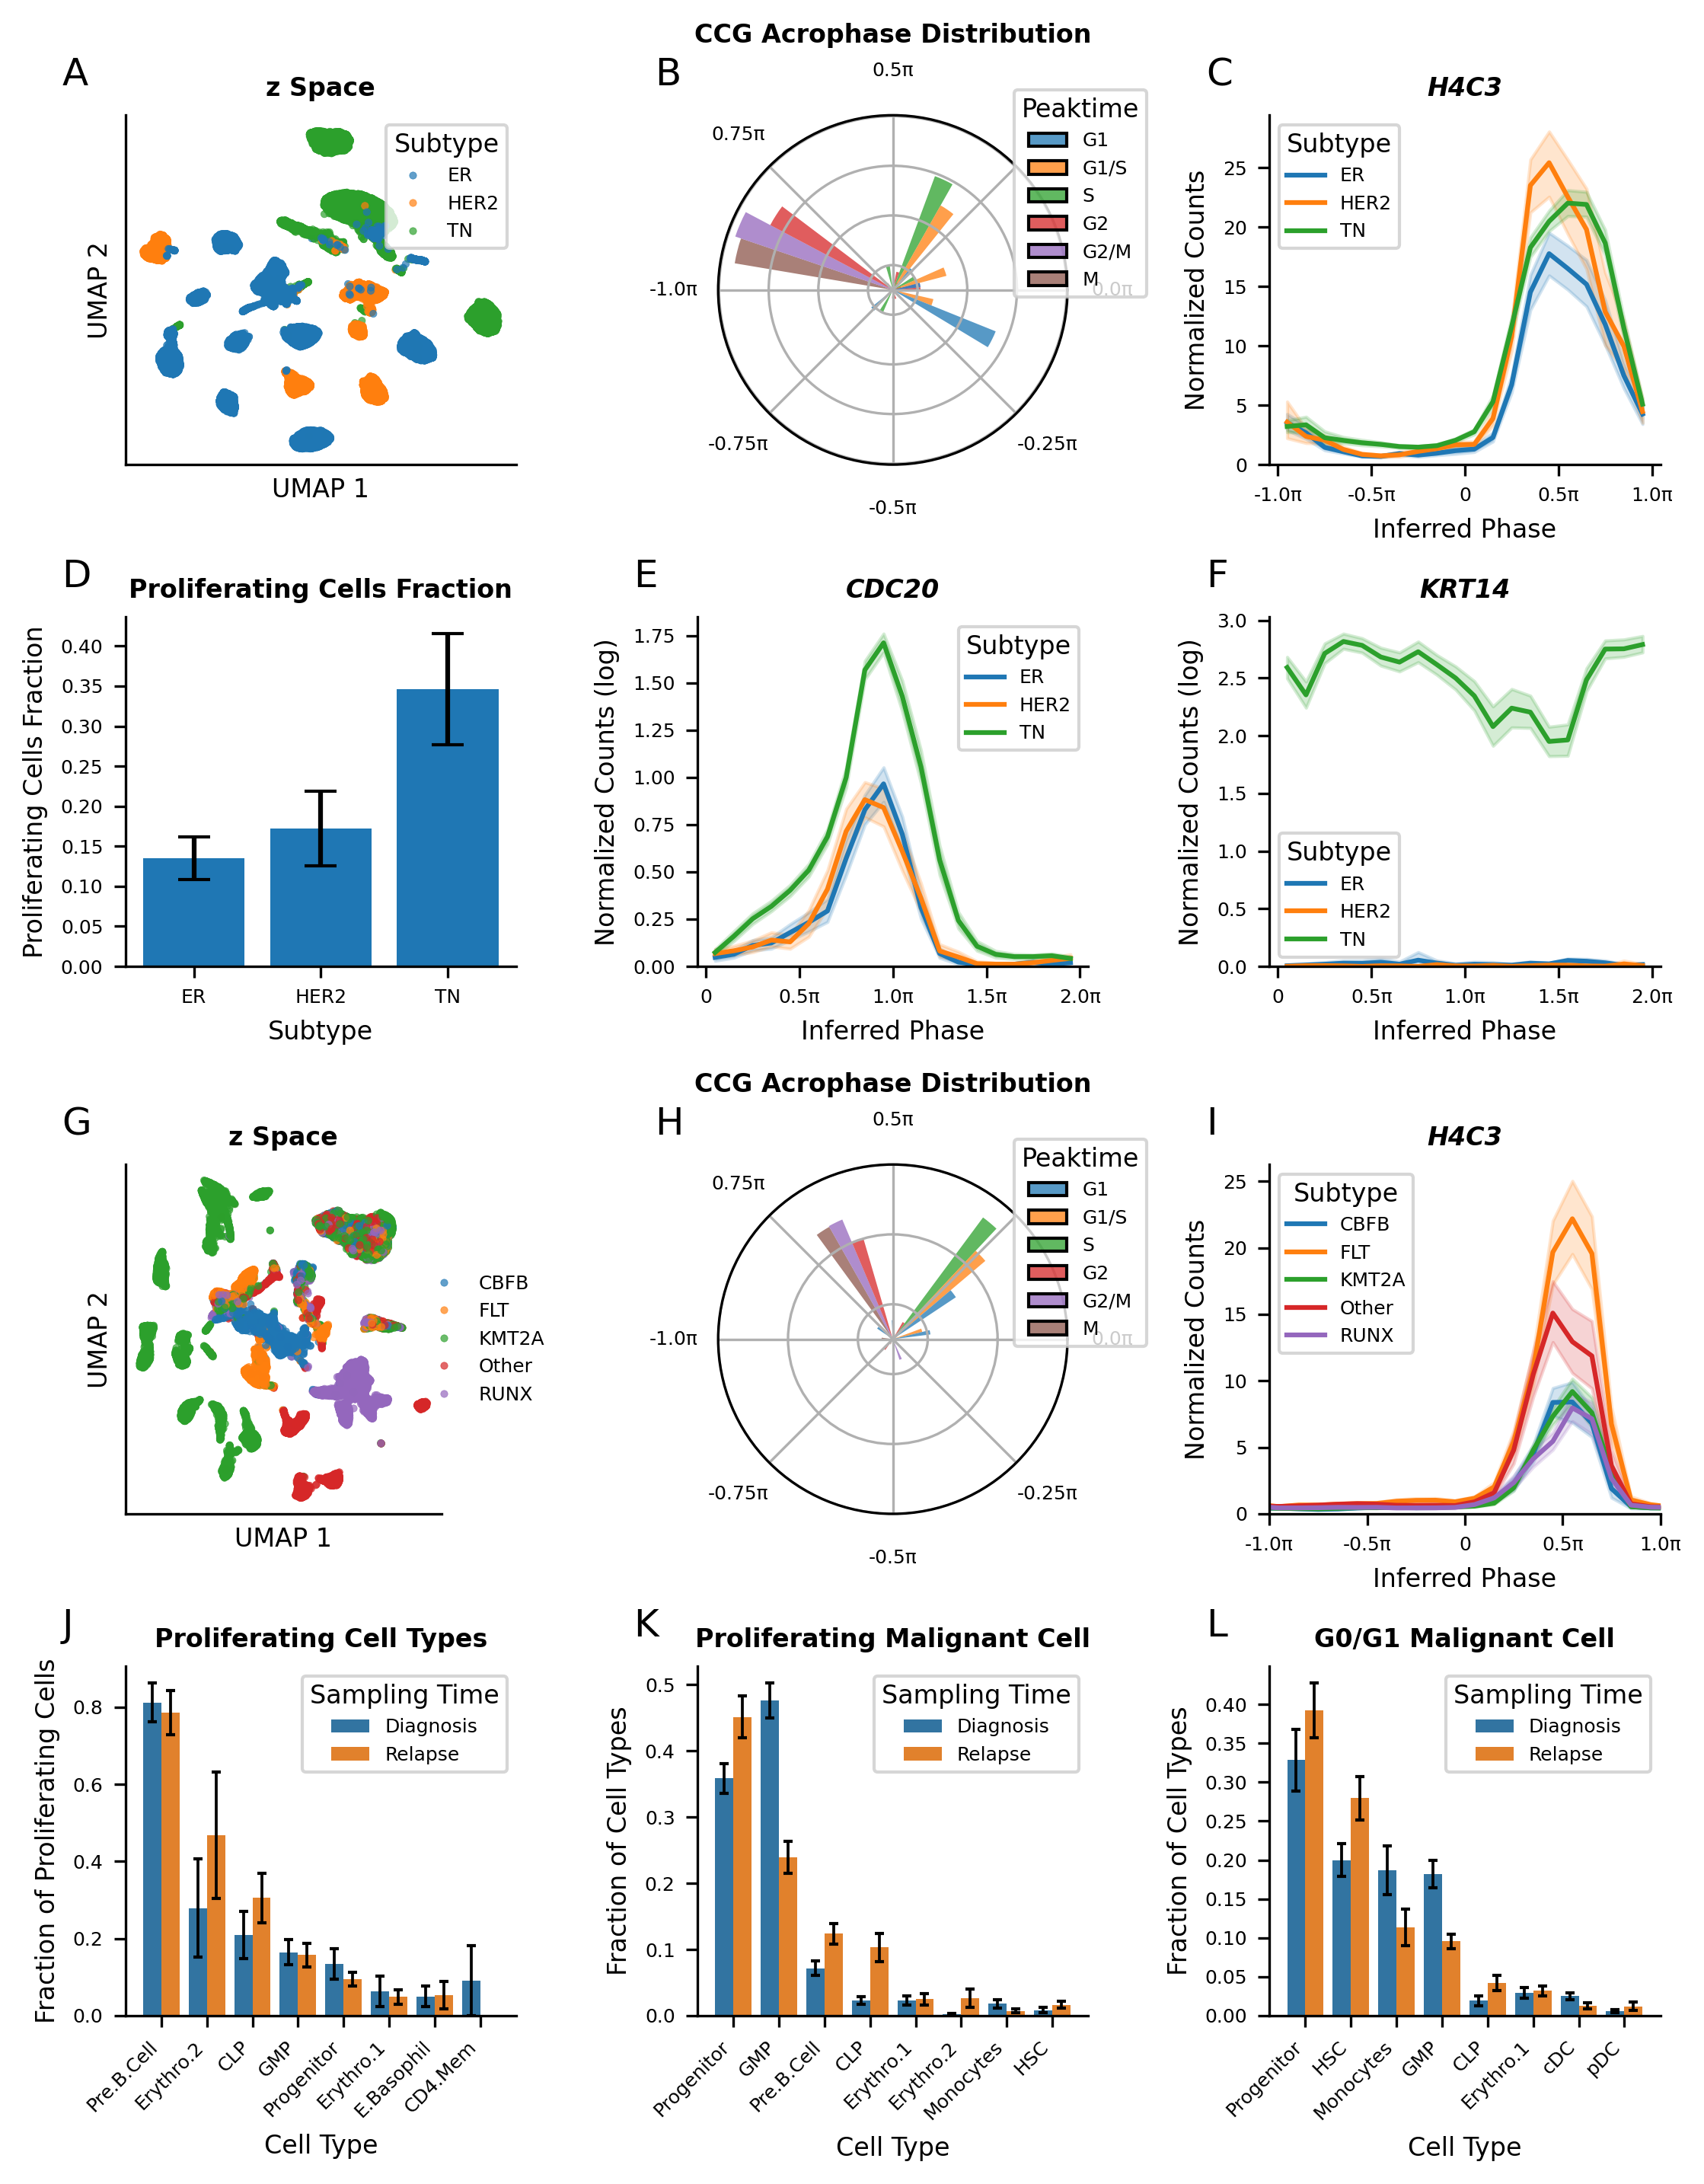

In [34]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)
plot_helpers.save_figure(
    fig,
    axs,
    "figure_3_cancer_python",
    mosaic=mosaic,
    to_remove_vertically=[-0.02, 0, -0.02],
)